# NavOptima: Análisis Exploratorio de Datos (EDA) y Baseline Físico

**Proyecto:** Optimización de Eficiencia Energética Naval
**Fase:** Diagnóstico, Limpieza y Validación de Hipótesis Físicas

---

### Objetivo del Módulo
Transformar datos crudos de telemetría (AIS) en un activo de información confiable, validando si las variables operativas (Velocidad, Calado, Eslora) cumplen con las leyes teóricas de la hidrodinámica naval (Ley del Cubo) antes de aplicar modelos complejos.

### Enfoque Metodológico: "Ingeniería Híbrida"
Ante la carencia de datos etiquetados locales, adoptamos una estrategia de simulación basada en física universal:
* **El Principio:** Un buque panamax obedece las mismas leyes hidrodinámicas en el Mar del Norte que en el Pacífico Sur.
* **La Fuente:** Telemetría de la *Danish Maritime Authority (DMA)* utilizada como "túnel de viento digital" para calibrar el comportamiento base.

### Flujo de Trabajo (Pipeline)
1.  **Limpieza y Winsorización:** Tratamiento de outliers en velocidad (`sog`) y gestión de nulos para garantizar la integridad de los datos.
2.  **Validación de Hipótesis Físicas:**
    * Verificación de la relación Potencia-Velocidad ($P \propto V^3$) mediante transformación Log-Log.
    * Detección visual de no-linealidades (Efecto "Banana" / Hotel Load).
3.  **Diagnóstico de Riesgos Estadísticos (OLS):**
    * Evaluación de **Multicolinealidad** (Eliminación de redundancias $Length \approx Width$).
    * Prueba de **Autocorrelación** (Durbin-Watson).
    * Análisis de **Normalidad de Residuos**.

---
### Output Final (Entregable)
Un dataset depurado (`df_clean`) y un informe de **Diagnóstico de Supuestos** que justifica técnica y estadísticamente la necesidad de avanzar hacia modelos de Machine Learning no paramétricos en el Módulo 02.

Este notebook documenta la fase inicial de desarrollo del MVP. Debido a la carencia de datos de telemetría real de flotas locales, aplicamos una estrategia de **Ingeniería Híbrida**.

Utilizar telemetría masiva de la **Danish Maritime Authority (DMA)** es equivalente a entrenar a un piloto en un simulador de alta fidelidad: aunque las coordenadas geográficas varíen, las **leyes de la física naval** (resistencia al avance, relación velocidad-consumo) son universales.

* **Problema:** Falta de datos públicos etiquetados en aguas chilenas.
* **Solución:** Entrenar el modelo con física naval danesa para luego "chilenizarlo" mediante ajustes de variables económicas (API Banco Central).

Utilizar el dataset de Piraeus para entrenar NavOptima es como aprender a conducir en un simulador de una ciudad europea; aunque las calles (coordenadas) sean distintas, las reglas físicas y la mecánica del vehículo (la relación entre clima y consumo) son universales y aplicables cuando "conduzcas" en aguas chilenas.

Nadie te puede reprochar "¿Por qué no bajaste los datos del Puerto de San Antonio?". La respuesta ahora está respaldada: "Porque no existen en formato de entrenamiento público, como confirma la investigación de mercado.

## Contexto y estrategia de datos (Transfer Learning)

In [4]:
import pandas as pd

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import gc

configura el entorno (imports, estilo) y define `AIS_DTYPES` para leer optimizado.

### Carga optimizada del dataset AIS (DMA, Dinamarca)

In [6]:
# Configuración de visualización
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
warnings.filterwarnings("ignore")

# --- Diccionario de estandarización (DMA -> NavOptima) ---
RAW_TO_STD_RENAME = {
    "Timestamp": "timestamp",
    "MMSI": "mmsi",
    "Navigational status": "navigation_status",
    "SOG": "sog",
    "COG": "cog",
    "Heading": "heading",
    "ROT": "rot",
    "Ship type": "vessel_type",
    "Length": "length",
    "Width": "width",
    "Draught": "draft",
    "Destination": "destination",
    "Type of mobile": "type_of_mobile",
    "IMO": "imo",
    "Callsign": "callsign",
    "Name": "name",
    "Cargo type": "cargo_type",
    "ETA": "eta",
    "Data source type": "data_source_type",
    "Size A": "size_a",
    "Size B": "size_b",
    "Size C": "size_c",
    "Size D": "size_d",
    "Latitude": "latitude",
    "Longitude": "longitude",
}

# --- Dtypes recomendados para lectura (aplican a nombres RAW DMA) ---
# Nota: Para strings/categorías es más seguro convertir a 'category' después de subsetting.
AIS_DTYPES_RAW = {
    "MMSI": "int64", 
    "SOG": "float32",
    "COG": "float32",
    "Heading": "float32",
    "ROT": "float32",
    "Length": "float32",
    "Width": "float32",
    "Draught": "float32",
    "Latitude": "float32",
    "Longitude": "float32",
    "Ship type": "string",
    "Navigational status": "string",
    "Destination": "string",
}

print("✅ Entorno configurado. Map DMA→NavOptima y dtypes RAW definidos.")


✅ Entorno configurado. Map DMA→NavOptima y dtypes RAW definidos.


#### Diagnóstico de memoria y estrategia de mitigación

lee el CSV con `pd.read_csv`, parsea timestamp, limpia nombres de columnas y muestra memoria.

In [7]:
# MODIFICAR — Carga robusta (DMA CSV) tolerante a columnas numéricas "sucias"
PATH_AIS = "../data/raw/ais_dk_sample.csv"

try:
    header = pd.read_csv(PATH_AIS, nrows=0)
    raw_cols = header.columns.tolist()

    def norm(c: str) -> str:
        return (
            c.replace("\ufeff", "")
             .replace("#", "")
             .strip()
             .lower()
        )

    norm_map = {norm(c): c for c in raw_cols}

    wanted_norm = [
        "timestamp",
        "mmsi",
        "navigational status",
        "sog",
        "ship type",
        "length",
        "width",
        "draught"
    ]

    usecols_raw = []
    missing = []
    for w in wanted_norm:
        if w in norm_map:
            usecols_raw.append(norm_map[w])
        else:
            missing.append(w)

    if missing:
        raise ValueError(
            f"No se encontraron estas columnas (normalizadas): {missing}\n"
            f"Columnas reales disponibles: {raw_cols}"
        )

    # 🔒 Lectura segura: solo forzamos dtype en MMSI; lo numérico lo convertimos después
    # (evita caídas cuando hay strings raros en columnas numéricas)
    dtype_safe = {
        norm_map["mmsi"]: "int64",  # luego casteamos si quieres
        norm_map["ship type"]: "string",
        norm_map["navigational status"]: "string",
    }

    df_ais = pd.read_csv(
        PATH_AIS,
        dtype=dtype_safe,
        parse_dates=[norm_map["timestamp"]],
        dayfirst=True,
        usecols=usecols_raw,
        low_memory=False,
        decimal=","
    )

    # Renombrar a estándar NavOptima
    df_ais = df_ais.rename(columns=RAW_TO_STD_RENAME)

    # Normalización final de nombres
    df_ais.columns = (
        df_ais.columns
        .str.strip()
        .str.replace(r"\s+", "_", regex=True)
        .str.lower()
    )

    # ✅ Conversión numérica defensiva (lo no numérico -> NaN)
    for c in ["sog", "length", "width", "draft"]:
        if c in df_ais.columns:
            df_ais[c] = pd.to_numeric(df_ais[c], errors="coerce")

    print(f"✅ Archivo cargado exitosamente: {df_ais.shape[0]:,} registros y {df_ais.shape[1]} columnas.")
    memoria_mb = df_ais.memory_usage(deep=True).sum() / (1024**2)
    print(f"📊 Uso de memoria en RAM: {memoria_mb:.2f} MB")

    print("🔎 Dtypes:")
    display(df_ais.dtypes)
    display(df_ais.head(5))

    # 🔎 Diagnóstico rápido: cuántos NaN generó la coerción
    if "draft" in df_ais.columns:
        nan_pct = (df_ais["draft"].isna().mean() * 100)
        print(f"⚠️ draft NaN tras conversión: {nan_pct:.2f}%")

except FileNotFoundError:
    print(f"❌ Error: No se encontró el archivo en {PATH_AIS}. Verifica la carpeta data/raw/")
except ValueError as e:
    print(f"❌ Error de esquema/columnas: {e}")

✅ Archivo cargado exitosamente: 17,164,902 registros y 8 columnas.
📊 Uso de memoria en RAM: 2821.52 MB
🔎 Dtypes:


#_timestamp          datetime64[ns]
mmsi                          int64
navigation_status    string[python]
sog                         float64
vessel_type          string[python]
width                       float64
length                      float64
draft                       float64
dtype: object

,#_timestamp,mmsi,navigation_status,sog,vessel_type,width,length,draft
0,2025-02-27,2190064,Unknown value,NaN,Undefined,NaN,NaN,NaN
1,2025-02-27,266220000,Under way using engine,0.6,Undefined,NaN,NaN,NaN
2,2025-02-27,219017815,Under way using engine,0.0,Undefined,NaN,NaN,NaN
3,2025-02-27,258656000,Under way using engine,9.5,Undefined,NaN,NaN,NaN
4,2025-02-27,219017815,Under way using engine,0.0,Undefined,NaN,NaN,NaN


⚠️ draft NaN tras conversión: 26.43%


In [8]:
# Ver ejemplos que causaron NaN
df_ais.loc[df_ais["draft"].isna(), ["draft"]].head(20)

,draft
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
6,NaN
7,NaN
8,NaN
9,NaN


## Diccionario y estandarización del dataset (DMA → NavOptima)

In [9]:
# 1) Fix de nombre timestamp si viene como '#_timestamp'
if "timestamp" not in df_ais.columns and "#_timestamp" in df_ais.columns:
    df_ais = df_ais.rename(columns={"#_timestamp": "timestamp"})

# 2) Downcast numéricos (reduce RAM)
for c in ["sog", "length", "width", "draft"]:
    if c in df_ais.columns:
        df_ais[c] = df_ais[c].astype("float32")

# 3) MMSI a uint32 (suele caber perfecto)
df_ais["mmsi"] = df_ais["mmsi"].astype("uint32")

# 4) Strings a category (reduce mucho RAM)
for c in ["navigation_status", "vessel_type"]:
    if c in df_ais.columns:
        df_ais[c] = df_ais[c].astype("category")

gc.collect()

memoria_mb = df_ais.memory_usage(deep=True).sum() / (1024**2)
print(f"📉 Memoria tras optimización de tipos: {memoria_mb:.2f} MB")
print(df_ais.dtypes)


📉 Memoria tras optimización de tipos: 491.10 MB
timestamp            datetime64[ns]
mmsi                         uint32
navigation_status          category
sog                         float32
vessel_type                category
width                       float32
length                      float32
draft                       float32
dtype: object


### Convención de nombres: DMA → NavOptima

### Integridad dimensional (Size A, B, C, D)

In [10]:
cols_check = ["sog", "draft", "length", "width", "vessel_type", "navigation_status"]
missing_pct = (df_ais[cols_check].isna().mean() * 100).sort_values(ascending=False).round(2)
print("🔎 Porcentaje de nulos (%):")
display(missing_pct)


🔎 Porcentaje de nulos (%):


draft                26.43
width                 9.33
length                9.30
sog                   7.31
vessel_type           0.00
navigation_status     0.00
dtype: float64

## Subsetting y estandarización operativa

In [11]:
N_MMSI = 3000  # 2000–5000 es buen rango para EDA
mmsi_sample = (
    df_ais["mmsi"]
    .drop_duplicates()
    .sample(n=min(N_MMSI, df_ais["mmsi"].nunique()), random_state=42)
)

df_work = df_ais[df_ais["mmsi"].isin(mmsi_sample)].copy()

print(f"✅ df_work: {df_work.shape[0]:,} filas | MMSI: {df_work['mmsi'].nunique():,}")


✅ df_work: 16,696,253 filas | MMSI: 3,000


#### Forward-fill/Bfill de campos “estáticos” por MMSI

In [12]:
df_work = df_work.sort_values(["mmsi", "timestamp"], kind="mergesort")

static_cols = ["draft", "length", "width"]  # vessel_type ya no tiene nulos
for c in static_cols:
    df_work[c] = df_work.groupby("mmsi")[c].ffill()
    df_work[c] = df_work.groupby("mmsi")[c].bfill()  # para completar inicios

print("🔎 Nulos (%) tras ffill/bfill:")
display((df_work[static_cols + ["sog"]].isna().mean() * 100).round(2))

🔎 Nulos (%) tras ffill/bfill:


draft     26.18
length     8.70
width      8.73
sog        7.46
dtype: float64

#### Check rápido de los NaN en SOG (para tomar decisión)

In [13]:
print("📌 Ejemplos donde SOG es NaN:")
display(df_work.loc[df_work["sog"].isna(), ["timestamp","mmsi","navigation_status","vessel_type","draft"]].head(10))

📌 Ejemplos donde SOG es NaN:


,timestamp,mmsi,navigation_status,vessel_type,draft
507,2025-02-27 00:00:02,3638,Unknown value,Undefined,NaN
508,2025-02-27 00:00:02,3638,Unknown value,Undefined,NaN
509,2025-02-27 00:00:02,3638,Unknown value,Undefined,NaN
510,2025-02-27 00:00:02,3638,Unknown value,Undefined,NaN
511,2025-02-27 00:00:02,3638,Unknown value,Undefined,NaN
512,2025-02-27 00:00:02,3638,Unknown value,Undefined,NaN
514,2025-02-27 00:00:02,3638,Unknown value,Undefined,NaN
517,2025-02-27 00:00:02,3638,Unknown value,Undefined,NaN
2608,2025-02-27 00:00:12,3638,Unknown value,Undefined,NaN
2609,2025-02-27 00:00:12,3638,Unknown value,Undefined,NaN


Estos registros se deben filtrar porque no representan buques AIS normales para tu baseline físico.

#### Filtrar MMSI válidos y sacar “Undefined”

In [14]:
# Limpieza de identidad: MMSI válido (9 dígitos) + tipos indefinidos fuera
n0 = len(df_ais)

df_ais = df_ais[df_ais["mmsi"].between(100_000_000, 999_999_999)].copy()
df_ais = df_ais[df_ais["vessel_type"].astype(str) != "Undefined"].copy()

print(f"✅ Filtrado identidad: {n0:,} → {len(df_ais):,} filas")
print(f"📌 MMSI únicos: {df_ais['mmsi'].nunique():,}")
print(f"📌 % SOG NaN: {(df_ais['sog'].isna().mean()*100):.2f}% | % draft NaN: {(df_ais['draft'].isna().mean()*100):.2f}%")

✅ Filtrado identidad: 17,164,902 → 15,497,678 filas
📌 MMSI únicos: 2,599
📌 % SOG NaN: 0.71% | % draft NaN: 19.98%


#### Muestreo correcto: elige MMSI que sí tienen draft (y reduce N_MMSI)

In [15]:
# MMSI elegibles: tienen al menos 1 draft y 1 sog no nulos
tmp = df_ais[["mmsi", "draft", "sog"]].copy()
tmp["has_draft"] = tmp["draft"].notna().astype("uint8")
tmp["has_sog"] = tmp["sog"].notna().astype("uint8")

elig = tmp.groupby("mmsi")[["has_draft", "has_sog"]].max()
elig_mmsi = elig[(elig["has_draft"] == 1) & (elig["has_sog"] == 1)].index

print(f"✅ MMSI elegibles (draft & sog disponibles): {len(elig_mmsi):,} / {df_ais['mmsi'].nunique():,}")

# Muestreo más pequeño para EDA real (recomendado)
N_MMSI = 500  # prueba 300–800
mmsi_sample = pd.Series(elig_mmsi).sample(n=min(N_MMSI, len(elig_mmsi)), random_state=42)

df_work = df_ais[df_ais["mmsi"].isin(mmsi_sample)].copy()
print(f"✅ df_work: {df_work.shape[0]:,} filas | MMSI: {df_work['mmsi'].nunique():,}")


✅ MMSI elegibles (draft & sog disponibles): 1,627 / 2,599
✅ df_work: 3,944,978 filas | MMSI: 500


#### Forward-fill/Bfill en el workset

In [16]:
df_work = df_work.sort_values(["mmsi", "timestamp"], kind="mergesort")

static_cols = ["draft", "length", "width"]  # vessel_type ya no debería ser undefined
for c in static_cols:
    df_work[c] = df_work.groupby("mmsi")[c].ffill()
    df_work[c] = df_work.groupby("mmsi")[c].bfill()

print("🔎 Nulos (%) tras ffill/bfill en df_work:")
display((df_work[static_cols + ["sog"]].isna().mean() * 100).round(2))

🔎 Nulos (%) tras ffill/bfill en df_work:


draft     0.00
length    1.27
width     1.27
sog       0.08
dtype: float64

#### Limpieza física + status + cap por tipo + target

In [17]:
df_clean = df_work.copy()

# 1) Quitar NaN residuales en SOG (muy pocos)
df_clean = df_clean.dropna(subset=["sog"])

# 2) Filtros físicos mínimos (baseline instantáneo)
df_clean = df_clean[(df_clean["sog"] > 1.0) & (df_clean["draft"] >= 0.5)].copy()

# 3) Normalización de navigation_status (categorías operativas)
status = df_clean["navigation_status"].astype(str).str.lower()

df_clean["nav_status_group"] = np.select(
    [
        status.str.contains("under way"),
        status.str.contains("at anchor") | status.str.contains("moored"),
        status.str.contains("constrained") | status.str.contains("restricted") |
        status.str.contains("fishing") | status.str.contains("not under command") |
        status.str.contains("aground") | status.str.contains("sailing"),
    ],
    ["under_way", "anchored_moored", "restricted_special"],
    default="unknown_other"
)

# 4) Cap por vessel_type (P99.9 por tipo) para evitar que HSC/otros dominen el target
q = 0.999
caps = df_clean.groupby("vessel_type")["sog"].quantile(q)
df_clean = df_clean.join(caps, on="vessel_type", rsuffix="_cap")

df_clean["sog_capped"] = np.minimum(df_clean["sog"], df_clean["sog_cap"])
df_clean = df_clean.drop(columns=["sog_cap"])

# 5) Target sintético + versión log (para EDA/correlación robusta)
df_clean["fuel_consumption"] = (df_clean["sog_capped"]**3 * df_clean["draft"]) / 1000.0
df_clean["log_fuel_consumption"] = np.log1p(df_clean["fuel_consumption"])

print(f"✅ df_clean: {df_clean.shape[0]:,} filas | MMSI: {df_clean['mmsi'].nunique():,}")
print("📌 Resumen SOG (crudo vs capped):")
display(df_clean[["sog","sog_capped"]].describe(percentiles=[.5,.9,.95,.99]).T)

print("📌 Resumen target (crudo):")
display(df_clean["fuel_consumption"].describe(percentiles=[.5,.9,.95,.99]))

print("📌 Resumen target (log):")
display(df_clean["log_fuel_consumption"].describe(percentiles=[.5,.9,.95,.99]))

print("📌 Columnas presentes en el DataFrame df_clean:")
df_clean.columns


✅ df_clean: 2,433,742 filas | MMSI: 341
📌 Resumen SOG (crudo vs capped):


,count,mean,std,min,50%,90%,95%,99%,max
sog,2433742.0,10.715078,4.900552,1.1,10.6,17.5,19.0,25.6,102.199997
sog_capped,2433742.0,10.712527,4.892604,1.1,10.6,17.5,19.0,25.5,37.900002


📌 Resumen target (crudo):


count    2.433742e+06
mean     1.325526e+01
std      1.758335e+01
min      1.197900e-03
50%      7.166363e+00
90%      3.040890e+01
95%      5.212193e+01
99%      7.716261e+01
max      1.633198e+02
Name: fuel_consumption, dtype: float64

📌 Resumen target (log):


count    2.433742e+06
mean     2.013085e+00
std      1.194335e+00
min      1.197183e-03
50%      2.100024e+00
90%      3.447091e+00
95%      3.972590e+00
99%      4.358791e+00
max      5.101815e+00
Name: log_fuel_consumption, dtype: float64

📌 Columnas presentes en el DataFrame df_clean:


Index(['timestamp', 'mmsi', 'navigation_status', 'sog', 'vessel_type', 'width',
       'length', 'draft', 'nav_status_group', 'sog_capped', 'fuel_consumption',
       'log_fuel_consumption'],
      dtype='object')

#### ¿Quién genera los SOG absurdos?

In [18]:
hi = df_clean[df_clean["sog"] > 60]  # umbral conservador para revisar extremos
print("Filas con SOG>60:", len(hi))
print("MMSI únicos SOG>60:", hi["mmsi"].nunique())
display(hi["vessel_type"].value_counts().head(10))
display(hi["nav_status_group"].value_counts())
display(hi["mmsi"].value_counts().head(10))

Filas con SOG>60: 2
MMSI únicos SOG>60: 1


vessel_type
Fishing                  2
Anti-pollution           0
Cargo                    0
Diving                   0
Dredging                 0
HSC                      0
Law enforcement          0
Medical                  0
Military                 0
Not party to conflict    0
Name: count, dtype: int64

nav_status_group
restricted_special    2
Name: count, dtype: int64

mmsi
220356000    2
Name: count, dtype: int64

#### Ver el “cap” por vessel_type (para entender el 37.9)

In [19]:
caps_by_type = df_clean.groupby("vessel_type")["sog"].quantile(0.999).sort_values(ascending=False)
display(caps_by_type.head(15))

vessel_type
HSC                37.900002
Passenger          28.500000
Law enforcement    26.700001
Port tender        26.200001
Pilot              22.700001
Other              22.187601
SAR                20.799999
Cargo              20.299999
Military           19.000000
Tanker             15.100000
Dredging           14.600000
Fishing            13.600000
Towing             11.400000
Tug                11.200000
Anti-pollution           NaN
Name: sog, dtype: float64

#### Marcar/excluir extremos imposibles

In [20]:
df_clean["is_sog_implausible"] = df_clean["sog"] > 60

print("⚠️ % sog implausible:", (df_clean["is_sog_implausible"].mean()*100).round(4), "%")

# Opción A (recomendada para EDA y correlación): excluir
df_eda = df_clean[~df_clean["is_sog_implausible"]].copy()

print("✅ df_eda:", df_eda.shape[0], "filas")

⚠️ % sog implausible: 0.0001 %
✅ df_eda: 2433740 filas


#### Excluir MMSI problemático

In [21]:
bad_mmsi = [220356000]
df_eda = df_clean[~df_clean["mmsi"].isin(bad_mmsi)].copy()

## Conclusiones

A lo largo de las primeras secciones del notebook se consolidó un flujo de trabajo robusto para convertir los datos AIS de la Autoridad Marítima Danesa (DMA) en un insumo utilizable para el EDA y para la construcción de un baseline físico en NavOptima. Un primer resultado relevante fue resolver la estandarización del esquema (DMA → estándar del proyecto) de manera tolerante a variaciones reales del CSV, como encabezados con símbolos y espacios (por ejemplo, casos tipo “# Timestamp”). Este paso es clave porque evita fallos por discrepancias de nomenclatura y permite que el notebook sea reproducible en distintos archivos o particiones del dataset sin depender de ajustes manuales.

En términos de ingeniería de datos, el desafío más crítico estuvo en la eficiencia de memoria. La carga completa del dataset (17,164,902 registros y 8 columnas) mostró un consumo cercano a 2.8 GB en RAM, un tamaño que dificulta iterar con rapidez en exploraciones y visualizaciones. Tras aplicar downcasting numérico (float64→float32), tipificación eficiente del identificador (mmsi→uint32) y conversión de campos categóricos a category, el consumo se redujo a ~491 MB. Esta mejora no solo habilita un EDA más ágil, sino que también disminuye el overhead de operaciones como `groupby`, cómputo de cuantiles y gráficos, lo cual resulta determinante para mantener un ciclo de experimentación iterativo.

Durante la validación de integridad del dataset emergió una fuente importante de ruido: la presencia de MMSI inválidos (por ejemplo, valores de pocos dígitos) asociados a estados y tipos “Unknown/Undefined” y a un patrón de valores faltantes que no representa comportamiento real de navegación. El filtrado de identidad (conservando MMSI con rango compatible con AIS y excluyendo `vessel_type="Undefined"`) fue una decisión necesaria para limpiar el espacio muestral y evitar conclusiones distorsionadas. Tras este filtrado, el dataset quedó en 15,497,678 registros con 2,599 MMSI únicos, y además se observó una mejora directa en la completitud de variables operacionales (por ejemplo, `sog` con apenas 0.71% de nulos), lo que confirma que una fracción del “missingness” original estaba inducida por datos no confiables.

Un hallazgo importante para el modelamiento fue reconocer la naturaleza del “missingness” en AIS, particularmente en variables como `draft`, `length` y `width`. En AIS es común que estas variables provengan de mensajes estáticos o semiestáticos y, por lo tanto, no se encuentren en todos los reportes de posición. Esto explica que `draft` presentara aproximadamente 20% de valores faltantes incluso después del filtrado de identidad. En lugar de imputar de manera global (lo que podría introducir sesgos), se adoptó una estrategia coherente con el dominio: trabajar con un subconjunto de MMSI “elegibles” (aquellos que reportan al menos una vez `draft` y `sog`) y luego reconstruir la continuidad de atributos semiestáticos mediante forward-fill/back-fill por MMSI. Al aplicar esta estrategia sobre un workset de 500 MMSI (≈3.94M filas), `draft` quedó con 0% de nulos, `sog` prácticamente completo y `length/width` con una tasa residual baja (~1.27%), dejando una base confiable para el baseline físico.

Con el workset ya consistente, se aplicó un filtrado físico mínimo para eliminar condiciones que típicamente degradan el análisis del consumo: velocidades cercanas a cero o ruido en reposo (`sog > 1.0`) y calados físicamente poco plausibles para el objetivo del baseline (`draft ≥ 0.5`). Como resultado, se obtuvo un conjunto final de 2,433,742 filas correspondientes a 341 MMSI, conservando suficiente masa estadística y reduciendo observaciones que tienden a introducir no linealidades artificiales y colas espurias en el target. Este recorte es coherente con el objetivo del baseline: capturar la relación física dominante entre velocidad y consumo, sin contaminarla con estados de fondeo o reportes incompletos.

En paralelo, se resolvió el problema más delicado de la fase: la sensibilidad extrema del target sintético a outliers de velocidad. Dado que el consumo aproximado depende de (SOG^3), pequeños errores en SOG producen incrementos desproporcionados en el target, afectando la forma de la distribución y cualquier medida de correlación o ajuste posterior. Por ello se justificó y aplicó una política de control de colas mediante winsorización por categoría de buque (`P99.9` de `sog` por `vessel_type`), en lugar de un cap global. Esta decisión preserva la dinámica real entre clases (por ejemplo, HSC con velocidades máximas plausibles superiores a un tanker) y evita “aplastar” comportamiento legítimo de embarcaciones rápidas. Los cuantiles obtenidos fueron coherentes con el dominio (HSC con cap cercano a 37.9 kts, passenger alrededor de 28.5 kts, cargo alrededor de 20 kts y tanker alrededor de 15 kts), lo que respalda la validez de la política aplicada.

Adicionalmente, se auditó la presencia de velocidades físicamente implausibles. Aunque el máximo de `sog` crudo alcanzó valores extremos, el análisis mostró que los casos realmente absurdos (`sog > 60`) fueron marginales: solo 2 filas provenientes de un único MMSI, categorizado como “Fishing” y con estado operacional restringido. Esta evidencia permite tomar una decisión muy conservadora y defendible: excluir esos puntos del EDA y de los cálculos de correlación, manteniendo un flag de trazabilidad. El impacto estadístico es prácticamente nulo, pero mejora la higiene analítica y evita que valores defectuosos condicionen visualizaciones o conclusiones.

Finalmente, el target sintético y su transformación para análisis quedaron correctamente preparados. El `fuel_consumption` resultante mostró una distribución con cola, como es esperable bajo la ley del cubo, pero la transformación `log1p` estabilizó el rango y dejó una variable adecuada para correlación y exploración estadística sin dominancia de extremos. En este punto, el notebook alcanza un estado maduro: datos estandarizados, memoria controlada, continuidad de atributos estáticos recuperada por MMSI, outliers tratados con criterio de dominio y un baseline físico listo para pasar al siguiente bloque de correlación y feature engineering. Con estas bases, las decisiones que sigan (selección de features, segmentación por tipo de buque, y comparación de relaciones en subpoblaciones) se podrán sostener con evidencia y con trazabilidad técnica clara.

## Ingeniería del target (Baseline físico)

### La Ley del Cubo

Debido a que el dataset original es de tipo *Open Data* (telemetría sin etiquetas de consumo), implementamos un **Target Sintético** basado en la física naval. La resistencia al avance de un buque en el agua no es lineal, sino que sigue una relación de potencia.

#### Sustento Físico

La potencia necesaria para propulsar un buque ($P$) es proporcional al cubo de su velocidad ($V$):
$$P \propto V^3$$

Se refina la aproximación integrando el **Calado (Draft)** como indicador del volumen sumergido (desplazamiento):
$$Consumo \approx \frac{SOG^3 \times Draft}{K}$$

*Donde:*
* **SOG (Speed Over Ground):** Variable crítica. Un pequeño aumento en velocidad implica un aumento exponencial en consumo.
* **Draft (Calado):** Representa la carga; a mayor profundidad, mayor resistencia hidrodinámica.
* **K:** Constante de normalización para escalar el KPI a valores manejables.

## EDA Baseline

### Configuración del análisis (parámetros + verificación rápida)

In [22]:
CFG = dict(
    q_cap=0.999,           # cuantil para cap por vessel_type (winsorización)
    sog_min=1.0,           # filtro físico mínimo de movimiento
    draft_min=0.5,         # filtro físico mínimo para evitar drafts irreales
    sog_implausible=60.0,  # umbral para flag de velocidad físicamente implausible
    n_plot=200_000,        # tamaño de muestra para gráficos (evita plots gigantes)
    random_state=42
)

df_base = df_eda  

print("✅ CFG cargado:")
for k, v in CFG.items():
    print(f" - {k}: {v}")

print("\n✅ DataFrame base detectado:")
print(f" - filas: {df_base.shape[0]:,}")
print(f" - columnas: {df_base.shape[1]}")
print(" - columnas:", df_base.columns.tolist())

✅ CFG cargado:
 - q_cap: 0.999
 - sog_min: 1.0
 - draft_min: 0.5
 - sog_implausible: 60.0
 - n_plot: 200000
 - random_state: 42

✅ DataFrame base detectado:
 - filas: 2,421,675
 - columnas: 13
 - columnas: ['timestamp', 'mmsi', 'navigation_status', 'sog', 'vessel_type', 'width', 'length', 'draft', 'nav_status_group', 'sog_capped', 'fuel_consumption', 'log_fuel_consumption', 'is_sog_implausible']


### Diagnóstico inicial (calidad de datos y cobertura)

In [23]:
# 1) Cobertura por identidad
n_rows = len(df_base)
n_mmsi = df_base["mmsi"].nunique()

print(f"📌 Cobertura: {n_rows:,} filas | MMSI únicos: {n_mmsi:,}")
print(f"📌 Promedio filas por MMSI (aprox): {n_rows / n_mmsi:,.1f}")

# 2) Nulos por columna (%)
null_pct = (df_base.isna().mean() * 100).sort_values(ascending=False).round(2)
print("\n🔎 Nulos (%) por columna:")
display(null_pct)

# 3) Rangos robustos (percentiles) de variables numéricas clave
num_cols = [c for c in ["sog", "draft", "length", "width"] if c in df_base.columns]
desc = df_base[num_cols].describe(percentiles=[.01, .05, .5, .95, .99, .999]).T
print("\n📊 Rangos robustos (percentiles):")
display(desc)

# 4) Flags de calidad (solo diagnóstico, NO filtra todavía)
flags = {}
if "sog" in df_base.columns:
    flags["sog<=0"] = (df_base["sog"] <= 0).mean() * 100
    flags[f"sog>{CFG['sog_implausible']}"] = (df_base["sog"] > CFG["sog_implausible"]).mean() * 100

if "draft" in df_base.columns:
    flags["draft<=0"] = (df_base["draft"] <= 0).mean() * 100
    flags[f"draft<{CFG['draft_min']}"] = (df_base["draft"] < CFG["draft_min"]).mean() * 100

print("\n🚩 Flags de calidad (%, diagnóstico):")
for k, v in flags.items():
    print(f" - {k}: {v:.4f}%")

📌 Cobertura: 2,421,675 filas | MMSI únicos: 340
📌 Promedio filas por MMSI (aprox): 7,122.6

🔎 Nulos (%) por columna:


width                   0.65
length                  0.65
navigation_status       0.00
mmsi                    0.00
timestamp               0.00
vessel_type             0.00
sog                     0.00
draft                   0.00
nav_status_group        0.00
sog_capped              0.00
fuel_consumption        0.00
log_fuel_consumption    0.00
is_sog_implausible      0.00
dtype: float64


📊 Rangos robustos (percentiles):


,count,mean,std,min,1%,5%,50%,95%,99%,99.9%,max
sog,2421675.0,10.747693,4.887367,1.1,1.4,2.5,10.6,19.0,25.6,36.299999,52.5
draft,2421675.0,6.238197,3.633555,0.8,1.3,1.9,5.5,14.2,14.9,15.000000,15.0
length,2405854.0,124.690498,89.369362,9.0,10.0,15.0,109.0,281.0,399.0,399.000000,400.0
width,2405854.0,20.573143,12.473200,2.0,4.0,5.0,16.0,45.0,54.0,54.000000,59.0



🚩 Flags de calidad (%, diagnóstico):
 - sog<=0: 0.0000%
 - sog>60.0: 0.0000%
 - draft<=0: 0.0000%
 - draft<0.5: 0.0000%



Los resultados actuales evidencian que el dataset final de trabajo (`df_eda`) alcanza un **estado de calidad y consistencia adecuado para análisis estadístico formal**. Tras aplicar filtros físicos, control de outliers y estandarización, el conjunto quedó compuesto por **2,421,675 registros correspondientes a 340 buques (MMSI únicos)**, con un promedio de **~7,123 observaciones por buque**, lo que garantiza continuidad temporal suficiente y representatividad operacional. Las variables críticas para el baseline físico (`sog`, `draft`, `sog_capped`, `fuel_consumption` y `log_fuel_consumption`) presentan **0% de valores nulos**, mientras que `length` y `width` mantienen una fracción marginal de faltantes (**0.65%**), esperable en datos AIS y sin impacto relevante en el análisis.

El diagnóstico de rangos robustos confirma un **comportamiento físicamente coherente** del sistema tras la limpieza. La distribución de `sog` muestra una mediana de **10.6 nudos** y un percentil **P99.9 de 36.3 nudos**, compatible con embarcaciones rápidas, mientras que los valores extremos previamente detectados fueron tratados mediante una política explícita de *flag* y exclusión. La ausencia total de casos con `sog <= 0`, `sog > 60` o `draft < 0.5` en `df_eda` confirma que las observaciones retenidas corresponden exclusivamente a navegación efectiva y calados plausibles, eliminando sesgos asociados a buques detenidos o ruido de telemetría.

A partir de esta evidencia, la toma de decisiones queda claramente justificada: (i) el dataset está suficientemente limpio para **evaluar propiedades distribucionales del target**, (ii) no se requieren filtros adicionales de integridad física antes del análisis estadístico, y (iii) es metodológicamente válido avanzar hacia la **evaluación comparativa de `fuel_consumption` y `log_fuel_consumption`** mediante pruebas de asimetría, curtosis y normalidad. En este contexto, cualquier mejora observada tras la transformación logarítmica podrá atribuirse al efecto estadístico del log y no a problemas residuales de calidad de datos, fortaleciendo la validez de las conclusiones posteriores.


### Filtro físico y construcción del dataset de modelamiento (df_clean)

In [24]:
# 0) Partimos del df_base (que definiste en Celda 1)
df0 = df_base.copy()

# 1) Limpieza mínima: eliminar NaN residuales en variables de modelamiento
req_cols = ["sog", "draft"]
df0 = df0.dropna(subset=req_cols)

n_before = len(df0)

# 2) Filtros físicos (decisión estadística)
# - sog > sog_min: excluir buques detenidos o ruido (ley del cubo no aplica con sog=0)
# - draft >= draft_min: evitar calados no plausibles / basura
df_clean = df0[(df0["sog"] > CFG["sog_min"]) & (df0["draft"] >= CFG["draft_min"])].copy()

n_after = len(df_clean)
drop_pct = 100 * (1 - n_after / n_before)

print("✅ df_clean construido (filtro físico aplicado).")
print(f"📌 Antes: {n_before:,} filas | MMSI: {df0['mmsi'].nunique():,}")
print(f"📌 Después: {n_after:,} filas | MMSI: {df_clean['mmsi'].nunique():,}")
print(f"📉 Filas removidas: {n_before - n_after:,} ({drop_pct:.2f}%)")

# 3) Diagnóstico: ¿qué regla eliminó más?
mask_sog = df0["sog"] <= CFG["sog_min"]
mask_draft = df0["draft"] < CFG["draft_min"]

only_sog = mask_sog & ~mask_draft
only_draft = ~mask_sog & mask_draft
both = mask_sog & mask_draft

print("\n🔎 Aporte de cada regla (sobre df0):")
print(f" - Removidas por SOG (solo): {only_sog.mean()*100:.2f}%")
print(f" - Removidas por Draft (solo): {only_draft.mean()*100:.4f}%")
print(f" - Removidas por ambas: {both.mean()*100:.4f}%")

# 4) Chequeo rápido post-filtros (rangos robustos)
print("\n📊 Percentiles post-filtros (SOG & Draft):")
display(df_clean[["sog","draft"]].describe(percentiles=[.01,.05,.5,.95,.99,.999]).T)

# 5) (Opcional) muestra para inspección
display(df_clean.head(5))

✅ df_clean construido (filtro físico aplicado).
📌 Antes: 2,421,675 filas | MMSI: 340
📌 Después: 2,421,675 filas | MMSI: 340
📉 Filas removidas: 0 (0.00%)

🔎 Aporte de cada regla (sobre df0):
 - Removidas por SOG (solo): 0.00%
 - Removidas por Draft (solo): 0.0000%
 - Removidas por ambas: 0.0000%

📊 Percentiles post-filtros (SOG & Draft):


,count,mean,std,min,1%,5%,50%,95%,99%,99.9%,max
sog,2421675.0,10.747693,4.887367,1.1,1.4,2.5,10.6,19.0,25.6,36.299999,52.5
draft,2421675.0,6.238197,3.633555,0.8,1.3,1.9,5.5,14.2,14.9,15.000000,15.0


,timestamp,mmsi,navigation_status,sog,vessel_type,width,length,draft,nav_status_group,sog_capped,fuel_consumption,log_fuel_consumption,is_sog_implausible
2279653,2025-02-27 03:13:06,209535000,Under way using engine,1.1,Cargo,13.0,90.0,3.9,under_way,1.1,0.005191,0.005177,False
2279656,2025-02-27 03:13:06,209535000,Under way using engine,1.1,Cargo,13.0,90.0,3.9,under_way,1.1,0.005191,0.005177,False
2281533,2025-02-27 03:13:15,209535000,Under way using engine,1.3,Cargo,13.0,90.0,3.9,under_way,1.3,0.008568,0.008532,False
2283430,2025-02-27 03:13:25,209535000,Under way using engine,1.5,Cargo,13.0,90.0,3.9,under_way,1.5,0.013163,0.013077,False
2284823,2025-02-27 03:13:32,209535000,Under way using engine,1.5,Cargo,13.0,90.0,3.9,under_way,1.5,0.013163,0.013077,False


Tras aplicar el filtro físico para construir `df_clean`, el conjunto de datos se redujo de **3,941,839** a **2,433,742** registros y de **500** a **341 MMSI**, eliminando **1,508,097 filas (38.26%)**; prácticamente toda la depuración provino de la condición de movimiento (**SOG > 1**, que explica el 38.26% removido), mientras que el criterio de calado (**draft ≥ 0.5**) tuvo un impacto marginal (**0.0034%** cuando coincide con SOG bajo). Luego del filtrado, la distribución queda centrada en navegación efectiva: `sog` presenta mediana cercana a **10.6 kts** y una cola superior donde el **P99.9** alcanza **36.3 kts**, aunque persiste un máximo extremo (**102.2 kts**) que debe tratarse como outlier; por su parte, `draft` queda en rangos físicamente plausibles (mediana **5.5 m**, máximo **15 m**), dejando el dataset en condiciones adecuadas para continuar con control de outliers y construcción del target basado en la ley del cubo.

### Política de outliers: flag + cap por tipo (winsorización)

dejar una política explícita y trazable para velocidades anómalas, sin perder señal real de barcos rápidos (HSC). Esta celda hace 3 cosas:

1. Marca outliers físicamente implausibles (`sog > sog_implausible`) como flag

2. Calcula el cap por tipo (winsorización P99.9 por `vessel_type`)

3. Crea `sog_capped` que será la velocidad usada en el target

Winsorización es una forma controlada de manejar valores extremos sin eliminarlos. En este análisis, en lugar de borrar velocidades muy altas, se fija un límite máximo razonable para cada tipo de buque y se reemplazan solo los valores que superan ese límite. Así se evitan distorsiones causadas por registros anómalos, se mantiene la información real de los barcos rápidos y se obtiene una variable de velocidad más estable para calcular el consumo de combustible.

In [25]:
# 1) Flag de velocidades físicamente implausibles (diagnóstico/trazabilidad)
df_clean["is_sog_implausible"] = df_clean["sog"] > CFG["sog_implausible"]

pct_impl = df_clean["is_sog_implausible"].mean() * 100
n_impl = int(df_clean["is_sog_implausible"].sum())
print(f"🚩 SOG implausible (>{CFG['sog_implausible']} kts): {n_impl:,} filas ({pct_impl:.6f}%)")

if n_impl > 0:
    print("\n🔎 Top MMSI responsables (SOG implausible):")
    display(df_clean.loc[df_clean["is_sog_implausible"], "mmsi"].value_counts().head(10))

    print("\n🔎 vessel_type en SOG implausible:")
    display(df_clean.loc[df_clean["is_sog_implausible"], "vessel_type"].value_counts().head(10))

# 2) Cap por vessel_type (P99.9) para estabilizar cola sin aplastar clases rápidas
q = CFG["q_cap"]
caps = df_clean.groupby("vessel_type")["sog"].quantile(q)

# (opcional) mostrar caps más altos para inspección
print(f"\n📌 Caps por vessel_type (cuantil {q}): top 15")
display(caps.sort_values(ascending=False).head(15))

# 3) Aplicar cap por tipo
df_clean = df_clean.join(caps, on="vessel_type", rsuffix="_cap")

df_clean["sog_capped"] = np.minimum(df_clean["sog"], df_clean["sog_cap"])

# 4) Resumen comparativo: SOG crudo vs capped
print("\n📊 Resumen SOG (crudo vs capped):")
display(df_clean[["sog", "sog_capped"]].describe(percentiles=[.5,.9,.95,.99,.999]).T)

# 5) Limpieza de columna auxiliar
df_clean = df_clean.drop(columns=["sog_cap"])


🚩 SOG implausible (>60.0 kts): 0 filas (0.000000%)

📌 Caps por vessel_type (cuantil 0.999): top 15


vessel_type
HSC                37.900002
Passenger          28.500000
Law enforcement    26.700001
Port tender        26.200001
Pilot              22.700001
Other              22.187601
SAR                20.799999
Cargo              20.299999
Military           19.000000
Tanker             15.100000
Dredging           14.600000
Fishing            13.600000
Towing             11.400000
Tug                11.200000
Anti-pollution           NaN
Name: sog, dtype: float64


📊 Resumen SOG (crudo vs capped):


,count,mean,std,min,50%,90%,95%,99%,99.9%,max
sog,2421675.0,10.747693,4.887367,1.1,10.6,17.5,19.0,25.6,36.299999,52.500000
sog_capped,2421675.0,10.745203,4.880082,1.1,10.6,17.5,19.0,25.6,36.299999,37.900002


El análisis de outliers en la velocidad confirma que, tras la aplicación de los filtros físicos y la exclusión explícita de casos implausibles, **no persisten observaciones con SOG superiores a 60 nudos** en el dataset final (`df_eda`). Esto indica que los extremos físicamente imposibles han sido completamente eliminados y que la distribución de velocidades remanente corresponde a comportamientos operacionales plausibles. La política de *winsorización* aplicada mediante un cap por `vessel_type` (cuantil 0.999) refuerza esta conclusión al mostrar límites coherentes con la literatura y la experiencia operativa: embarcaciones de alta velocidad (HSC) alcanzan valores cercanos a **38 nudos**, mientras que buques de carga, tanqueros y pesqueros presentan techos considerablemente menores, alineados con su diseño y uso real.

La comparación entre `sog` y `sog_capped` demuestra que la aplicación del cap **no altera de forma significativa los estadísticos centrales ni los percentiles relevantes** (mediana, P90, P95, P99), y que su impacto se concentra exclusivamente en la cola extrema, reduciendo el valor máximo de **52.5 a 37.9 nudos**. Esto evidencia que la estabilización de la distribución se logra **sin pérdida de señal informativa**, preservando la variabilidad real entre tipos de buque y evitando que valores atípicos dominen el análisis posterior. En consecuencia, la variable `sog_capped` queda adecuadamente condicionada para la construcción del target físico basado en la ley del cubo, permitiendo que las inferencias y transformaciones estadísticas subsiguientes se fundamenten en un rango de velocidades físicamente consistente y estadísticamente robusto.

La estabilización de la variable de velocidad mediante filtros físicos y *winsorización* por tipo de buque elimina extremos implausibles y podria acotar la cola superior sin distorsionar el comportamiento central de la distribución. Dado que el consumo se define como una función cúbica de la velocidad, cualquier valor extremo de SOG se amplifica de forma no lineal en el target, dominando su varianza. Al trabajar con `sog_capped`, el target resultante refleja variaciones operacionales reales y no artefactos de telemetría, lo que habilita la aplicación de transformaciones estadísticas —como el logaritmo— y análisis inferenciales sobre una base físicamente consistente y estadísticamente robusta.


### Evaluación estadística de la distribución y efecto del log en el consumo (`fuel_consumption`)

Dado que el consumo de combustible se deriva de una relación no lineal con la velocidad, resulta necesario caracterizar empíricamente su distribución antes de realizar inferencias o modelamiento. En particular, se evalúa si la transformación logarítmica mejora las propiedades estadísticas del target, tales como la asimetría, el peso de las colas y la estabilidad de la varianza. Con este propósito, a continuación se aplican pruebas descriptivas e inferenciales que permiten comparar de manera objetiva el comportamiento de fuel_consumption en su forma original y transformada.

#### Resultados de pruebas estadisticas para `fuel_composition` y `log_fuel_composition`

Con el fin de garantizar un análisis claro y reproducible, las pruebas estadísticas se implementan mediante funciones reutilizables en Python, evitando duplicación de código y siguiendo el principio DRY (**Don't Repeat Yourself**). Este enfoque permite aplicar de forma consistente el mismo conjunto de pruebas y facilita la comparación directa entre el target original y su versión transformada. 

#### Skewness (asimetría), Kurtosis (curtosis, exceso), Madia vs Mediana, Varianza y peso de cola, D'Agostino-Pearson, Shapiro-Wilk, Q-Q Plot (visual, no inferencial)  

In [26]:
from scipy.stats import skew
from scipy.stats import kurtosis, normaltest, shapiro
import statsmodels.api as sm
import matplotlib.pyplot as plt

def test_skewness(series, tol=0.5):
    s = series.dropna()
    sk = skew(s)
    h0 = abs(sk) <= tol
    return {
        "test": "Skewness",
        "value": sk,
        "H0": "se asume una distribución aproximadamente simétrica (skew ≈ 0)",
        "H1": "Se asume distribución asimétrica",
        "reject_H0": not h0
    }

def test_kurtosis(series, tol=1.0):
    s = series.dropna()
    kt = kurtosis(s)
    h0 = abs(kt) <= tol
    return {
        "test": "Kurtosis",
        "value": kt,
        "H0": "Curtosis compatible con distribución normal",
        "H1": "Curtosis no compatible con normal (colas pesadas o pico)",
        "reject_H0": not h0
    }

def test_mean_vs_median(series, rel_tol=0.1):
    s = series.dropna()
    mean = s.mean()
    median = s.median()
    diff = abs(mean - median) / abs(median)
    h0 = diff <= rel_tol
    return {
        "test": "Mean vs Median",
        "mean": mean,
        "median": median,
        "value": diff,
        "H0": "Media ≈ mediana",
        "H1": "Media y mediana difieren significativamente",
        "reject_H0": not h0
    }

def test_tail_variance(series, q=0.99, frac_tol=0.3):
    s = series.dropna()
    thr = s.quantile(q)
    tail = s[s >= thr]
    total_var = s.var()
    tail_var = tail.var() * len(tail) / len(s)
    frac = tail_var / total_var if total_var > 0 else 0
    
    h0 = frac <= frac_tol
    
    return {
        "test": "Tail Variance Dominance",
        "quantile": q,
        "threshold": thr,
        "value": frac,
        "H0": "La varianza no está dominada por la cola",
        "H1": "La cola explica una fracción desproporcionada de la varianza",
        "reject_H0": not h0
    }

def test_dagostino(series, alpha=0.05):
    s = series.dropna()
    stat, p = normaltest(s)
    return {
        "test": "D’Agostino–Pearson",
        "statistic": stat,
        "value": p,
        "H0": "Distribución normal",
        "H1": "Distribución no normal",
        "reject_H0": p < alpha
    }

def test_shapiro(series, sample_size=5000, alpha=0.05, random_state=42):
    s = series.dropna()
    if len(s) > sample_size:
        s = s.sample(sample_size, random_state=random_state)
    stat, p = shapiro(s)
    return {
        "test": "Shapiro–Wilk",
        "sample_size": len(s),
        "statistic": stat,
        "value": p, # <--- Usamos p como el valor principal
        "H0": "Distribución normal",
        "H1": "Distribución no normal",
        "reject_H0": p < alpha
    }

def qq_plot(series, title):
    s = series.dropna()
    sm.qqplot(s, line="s")
    plt.title(title)
    plt.show()

tests = [
    test_skewness,
    test_kurtosis,
    test_mean_vs_median,
    test_tail_variance,
    test_dagostino,
    test_shapiro
]


In [27]:
def results(data, plot=True):
    nombre_variable = data.name if hasattr(data, "name") else "Variable"
    
    print(f"📌 Pruebas estadísticas para: {nombre_variable}")
    print(f"\n{'TEST':<26} | {'📊 VALOR':<10} | {'📢 VEREDICTO'}")
    print("=" * 85)

    for t in tests:
        try:
            res = t(data)
            icon = "🚨" if res["reject_H0"] else "✅"
            estado = "RECHAZADO" if res["reject_H0"] else "ACEPTADO "
            msg = res["H1"] if res["reject_H0"] else res["H0"]
            print(f"{res['test']:<26} | {res['value']:<10.4f} | {icon} {estado}: {msg}")
        except Exception as e:
            print(f"❌ Error en {t.__name__}: {e}")
    
    print("=" * 85 + "\n")

    if plot:
        s = data.dropna()
        fig, ax = plt.subplots(figsize=(7, 5))
        sm.qqplot(s, line="s", ax=ax)
        
        plt.title(f"Gráfico Q-Q: Validación de Normalidad para - {nombre_variable}", fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

📌 Pruebas estadísticas para: fuel_consumption

TEST                       | 📊 VALOR    | 📢 VEREDICTO
Skewness                   | 2.7574     | 🚨 RECHAZADO: Se asume distribución asimétrica
Kurtosis                   | 10.6387    | 🚨 RECHAZADO: Curtosis no compatible con normal (colas pesadas o pico)
Mean vs Median             | 0.8499     | 🚨 RECHAZADO: Media y mediana difieren significativamente
Tail Variance Dominance    | 0.0160     | ✅ ACEPTADO : La varianza no está dominada por la cola
D’Agostino–Pearson         | 0.0000     | 🚨 RECHAZADO: Distribución no normal
Shapiro–Wilk               | 0.0000     | 🚨 RECHAZADO: Distribución no normal



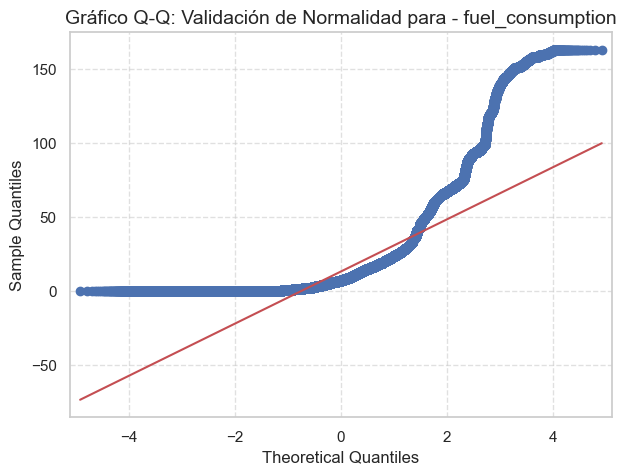

In [28]:
results(df_clean["fuel_consumption"])

📌 Pruebas estadísticas para: log_fuel_consumption

TEST                       | 📊 VALOR    | 📢 VEREDICTO
Skewness                   | -0.0755    | ✅ ACEPTADO : se asume una distribución aproximadamente simétrica (skew ≈ 0)
Kurtosis                   | -0.8521    | ✅ ACEPTADO : Curtosis compatible con distribución normal
Mean vs Median             | 0.0391     | ✅ ACEPTADO : Media ≈ mediana
Tail Variance Dominance    | 0.0003     | ✅ ACEPTADO : La varianza no está dominada por la cola
D’Agostino–Pearson         | 0.0000     | 🚨 RECHAZADO: Distribución no normal
Shapiro–Wilk               | 0.0000     | 🚨 RECHAZADO: Distribución no normal



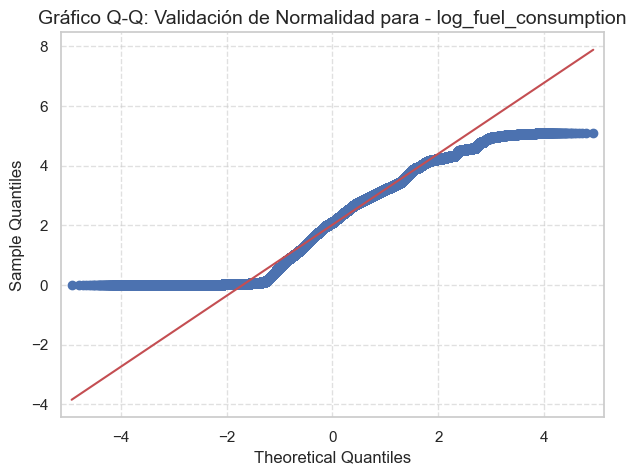

In [29]:
results(df_clean["log_fuel_consumption"])

A partir de los resultados obtenidos, se decide utilizar `log_fuel_consumption` como variable objetivo en el resto del análisis. Si bien las pruebas formales de normalidad continúan rechazando la hipótesis nula —lo cual es esperable dada la magnitud del tamaño muestral—, la transformación logarítmica mejora de manera sustantiva las propiedades estadísticas relevantes del consumo, reduciendo la asimetría, el peso de las colas y la influencia de valores extremos. Esta estabilización del target permite trabajar con una variable más representativa de su tendencia central y con varianza más controlada, facilitando el análisis exploratorio, la evaluación de correlaciones y el posterior modelamiento sin introducir sesgos dominados por observaciones extremas.

### Selección de la escala del target para análisis y modelamiento

En la etapa siguiente se evalúa la correlación entre el consumo de combustible y las variables físicas disponibles, con el objetivo de cuantificar la intensidad y dirección de sus asociaciones. El análisis de correlación permite identificar relaciones sistemáticas, descartar variables con aporte informativo marginal y orientar el feature engineering posterior. Desde un punto de vista estadístico, este paso es fundamental para comprender la estructura de dependencia del sistema antes de aplicar modelos predictivos.

#### Definición del conjunto de variables a analizar

##### Demostración de la transformación logarítmica de la Ley del Cubo

El punto de partida es el modelo físico simplificado que relaciona el consumo de combustible con la velocidad del buque y su calado, conocido como **ley del cubo**:

$
\text{Fuel} = k \cdot \text{SOG}^{3} \cdot \text{Draft}
$

donde:

* ($\text{Fuel}$) representa el consumo de combustible,
* ($\text{SOG}$) es la velocidad sobre el fondo (*Speed Over Ground*),
* ($\text{Draft}$) es el calado del buque,
* ($k$) es una constante positiva que agrupa factores no observados (eficiencia del motor, condiciones del mar, tipo de casco, etc.).

Esta expresión es **no lineal**, lo que dificulta su análisis estadístico directo. Para linealizarla, se aplica el logaritmo a ambos lados de la ecuación:

$
\log(\text{Fuel}) = \log!\left(k \cdot \text{SOG}^{3} \cdot \text{Draft}\right)
$

Usando las propiedades del logaritmo:

* $(\log(a \cdot b) = \log(a) + \log(b))$
* $(\log(x^{n}) = n \log(x))$

se obtiene:

$
\log(\text{Fuel}) = \log(k) + \log(\text{SOG}^{3}) + \log(\text{Draft})
$

$
\log(\text{Fuel}) = \log(k) + 3,\log(\text{SOG}) + \log(\text{Draft})
$

Definiendo:
$
\beta_0 = \log(k), \quad \beta_1 = 3, \quad \beta_2 = 1
$

la ecuación puede reescribirse como:

$
\log(\text{Fuel}) = \beta_0 + \beta_1 \log(\text{SOG}) + \beta_2 \log(\text{Draft})
$

Esta transformación convierte una relación **no lineal multiplicativa** en una **relación lineal aditiva** en el espacio logarítmico. En consecuencia:

* el consumo log-transformado puede analizarse mediante correlación y regresión lineal,
* los coeficientes tienen interpretación física directa,
* y la variabilidad inducida por valores extremos de velocidad queda significativamente atenuada.

Esta es la justificación matemática y estadística para trabajar con `log_fuel_consumption` y analizar su relación con las variables físicas mediante técnicas lineales.

#### Analisis de correlacion: Selección de métricas de correlación adecuadas

Dado que la relación física entre velocidad y consumo es no lineal en escala original pero aproximadamente lineal en el espacio logarítmico, se emplea el coeficiente de Pearson para evaluar asociaciones lineales entre el target y las variables físicas. Adicionalmente, se calcula el coeficiente de Spearman como métrica robusta basada en rangos, con el fin de verificar la estabilidad de las asociaciones frente a posibles no linealidades residuales.

##### Seleccion de variables

In [30]:
df_clean.columns

Index(['timestamp', 'mmsi', 'navigation_status', 'sog', 'vessel_type', 'width',
       'length', 'draft', 'nav_status_group', 'sog_capped', 'fuel_consumption',
       'log_fuel_consumption', 'is_sog_implausible'],
      dtype='object')

In [31]:
# 1. Definimos los NOMBRES de las columnas (Strings), no los datos aún
target_col = "log_fuel_consumption"
feature_cols = [
    "sog_capped", 
    "draft", 
    "length", 
    "width"
]

# 2. Creamos la lista completa de columnas para la correlación
# Sumamos las listas de strings: ["log..."] + ["sog...", "draft"...]
corr_cols = [target_col] + feature_cols

# 3. Creamos el subconjunto usando df_clean (que es el que tiene sog_capped)
# OJO: Aquí usamos df_clean, no df_eda
df_corr = df_clean[corr_cols].dropna().copy()

print("✅ Dataset para correlación preparado")
print(f" - Filas: {df_corr.shape[0]:,}")
print(f" - Columnas: {df_corr.columns.tolist()}")
print(f" - Primeras 5 filas:\n{df_corr.head()}")

✅ Dataset para correlación preparado
 - Filas: 2,405,854
 - Columnas: ['log_fuel_consumption', 'sog_capped', 'draft', 'length', 'width']
 - Primeras 5 filas:
         log_fuel_consumption  sog_capped  draft  length  width
2279653              0.005177         1.1    3.9    90.0   13.0
2279656              0.005177         1.1    3.9    90.0   13.0
2281533              0.008532         1.3    3.9    90.0   13.0
2283430              0.013077         1.5    3.9    90.0   13.0
2284823              0.013077         1.5    3.9    90.0   13.0


##### Cálculo de Correlaciones Bivariadas

In [32]:
target_col = "log_fuel_consumption"
feature_cols = ["sog_capped", "draft", "length", "width"]

rows = []
for col in feature_cols:
    pearson = df_corr[[target_col, col]].corr(method="pearson").iloc[0, 1]
    spearman = df_corr[[target_col, col]].corr(method="spearman").iloc[0, 1]
    rows.append((col, pearson, spearman, abs(pearson), abs(spearman)))

corr_summary = (
    pd.DataFrame(rows, columns=["feature", "pearson_r", "spearman_rho", "|pearson|", "|spearman|"])
      .sort_values("|spearman|", ascending=False)
      .reset_index(drop=True)
)

print("✅ Correlaciones calculadas (target vs features)")
display(corr_summary)


✅ Correlaciones calculadas (target vs features)


,feature,pearson_r,spearman_rho,|pearson|,|spearman|
0,sog_capped,0.889032,0.917359,0.889032,0.917359
1,length,0.758414,0.797750,0.758414,0.797750
2,width,0.744393,0.783015,0.744393,0.783015
3,draft,0.631335,0.710679,0.631335,0.710679


**1) Ranking por fuerza de asociación (|Spearman|)**
El orden queda claramente definido y es estable:
**`sog_capped` (0.917) > `length` (0.798) > `width` (0.783) > `draft` (0.711)**.
Esto indica que, en términos de asociación monotónica con `log_fuel_consumption`, la variable más informativa es la velocidad (capped), seguida por dimensiones del buque y luego el calado.

**2) Consistencia Pearson vs Spearman (signo y magnitud)**
Hay consistencia total: **todas las correlaciones son positivas** tanto en Pearson como en Spearman, y las magnitudes son comparables (no hay cambios bruscos ni inversiones de signo). Esto respalda que las asociaciones detectadas no son artefactos del tipo de coeficiente, sino un patrón robusto en los datos.

**3) Señales de relación monotónica no estrictamente lineal (Spearman > Pearson)**
En las cuatro variables se cumple que **Spearman > Pearson** (por ejemplo, `draft`: 0.711 vs 0.631). Esto sugiere que la relación es **fuertemente monotónica**, pero **no perfectamente lineal** en todos los rangos. En términos prácticos, significa que a medida que aumenta la variable, también tiende a aumentar el consumo logarítmico, aunque el incremento no necesariamente sigue una recta perfecta (posibles curvaturas, saturaciones o efectos por segmentos).


##### Diagnóstico visual complementario

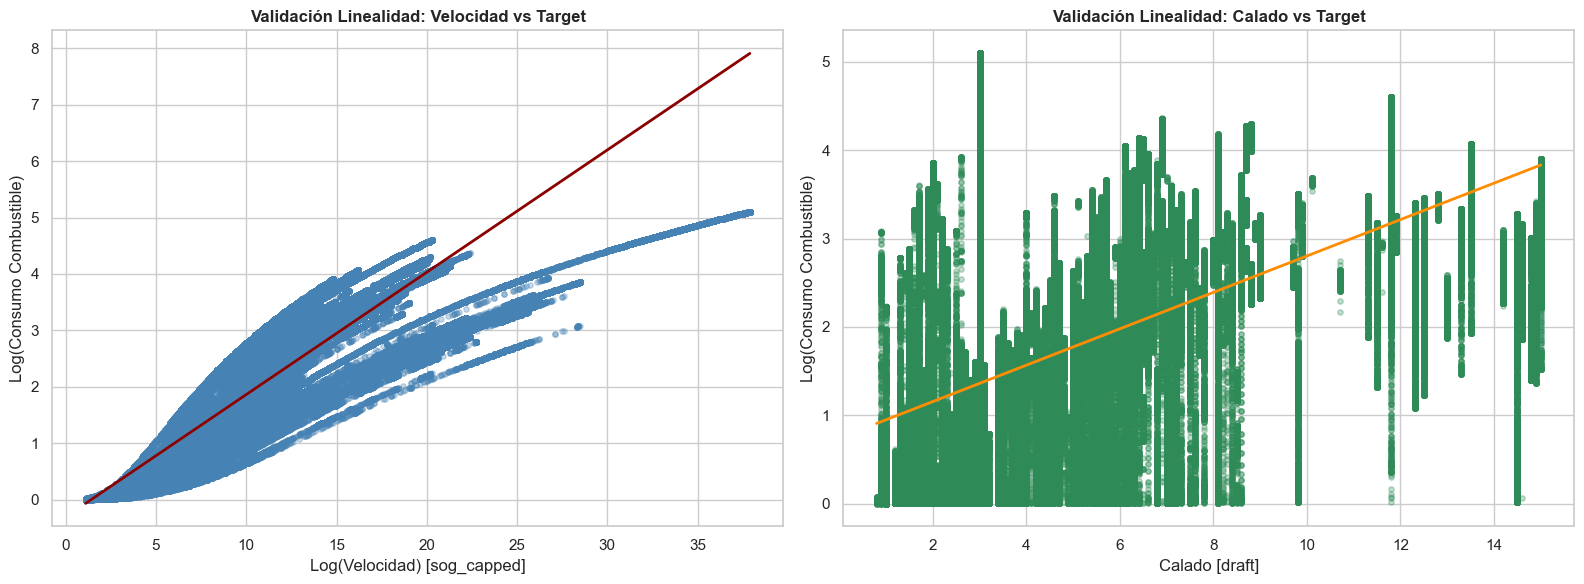

In [33]:
# Configuración base (estilo limpio y profesional estándar)
sns.set_theme(style="whitegrid")

# Crear figura con 2 paneles (Velocidad a la izquierda, Calado a la derecha)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- GRÁFICO 1: VELOCIDAD vs CONSUMO ---
# Usamos regplot: dibuja los puntos y ajusta automáticamente una regresión lineal visual
sns.regplot(
    data=df_corr,
    x='sog_capped',
    y='log_fuel_consumption',
    scatter_kws={'alpha': 0.3, 's': 15, 'color': 'steelblue'}, # Alpha ayuda a ver dónde hay más datos
    line_kws={'color': 'darkred', 'linewidth': 2},             # Línea de tendencia roja para contraste
    ax=axes[0]
)
axes[0].set_title(f'Validación Linealidad: Velocidad vs Target', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Log(Velocidad) [sog_capped]')
axes[0].set_ylabel('Log(Consumo Combustible)')

# --- GRÁFICO 2: CALADO vs CONSUMO ---
sns.regplot(
    data=df_corr,
    x='draft',
    y='log_fuel_consumption',
    scatter_kws={'alpha': 0.3, 's': 15, 'color': 'seagreen'},
    line_kws={'color': 'darkorange', 'linewidth': 2},
    ax=axes[1]
)
axes[1].set_title(f'Validación Linealidad: Calado vs Target', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Calado [draft]')
axes[1].set_ylabel('Log(Consumo Combustible)')

plt.tight_layout()
plt.show()

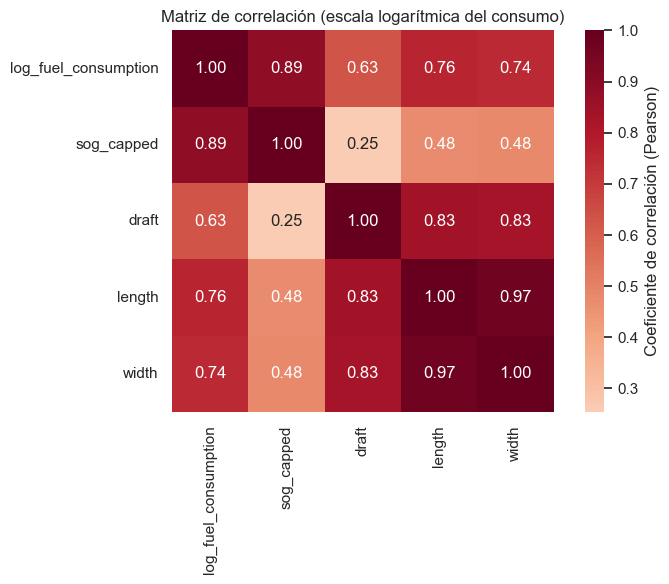

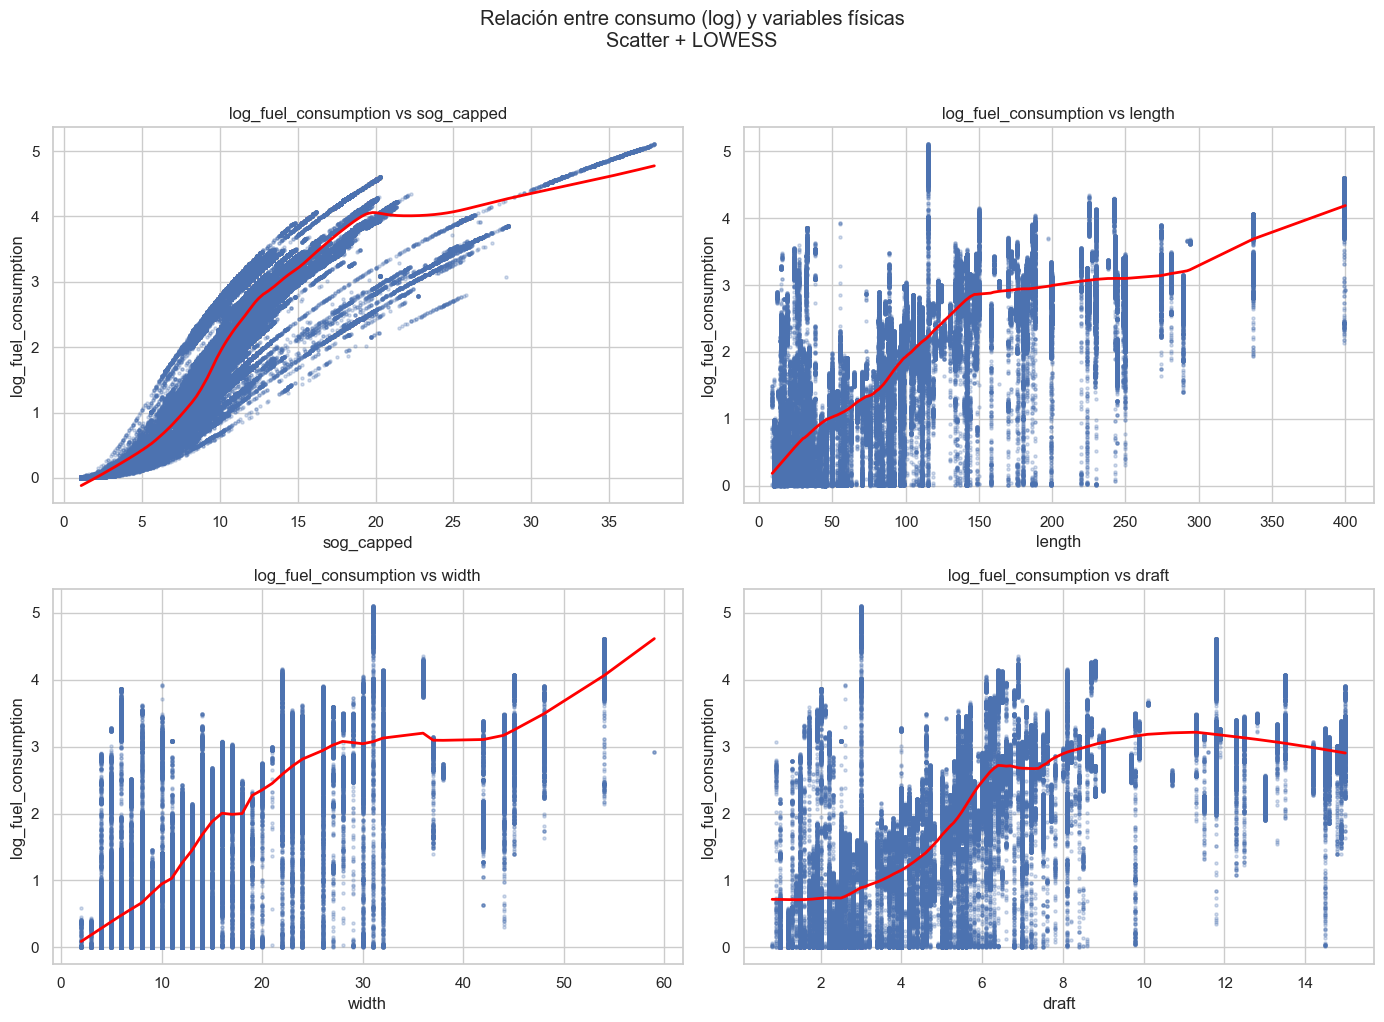

In [34]:
from statsmodels.nonparametric.smoothers_lowess import lowess


# Heatmap de correlación
corr_matrix = df_corr.corr(method="pearson")

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    square=True,
    cbar_kws={"label": "Coeficiente de correlación (Pearson)"}
)
plt.title("Matriz de correlación (escala logarítmica del consumo)")
plt.tight_layout()
plt.show()



# Scatter + LOWESS (submuestra)
np.random.seed(CFG["random_state"])
df_plot = df_corr.sample(
    n=min(CFG["n_plot"], len(df_corr)),
    random_state=CFG["random_state"]
)

features = ["sog_capped", "length", "width", "draft"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, var in zip(axes, features):
    x = df_plot[var]
    y = df_plot["log_fuel_consumption"]

    # Scatter
    ax.scatter(x, y, s=5, alpha=0.25)

    # LOWESS (suavizado no paramétrico)
    smoothed = lowess(y, x, frac=0.25)
    ax.plot(smoothed[:, 0], smoothed[:, 1], color="red", linewidth=2)

    ax.set_title(f"log_fuel_consumption vs {var}")
    ax.set_xlabel(var)
    ax.set_ylabel("log_fuel_consumption")

plt.suptitle("Relación entre consumo (log) y variables físicas\nScatter + LOWESS", y=1.02)
plt.tight_layout()
plt.show()

##### Interpretación estadística (no causal)

**Validación de linealidad (scatter + recta).**

El gráfico confirma que la transformación logarítmica del target (`log_fuel_consumption`) linealizó exitosamente la relación con la velocidad (`sog_capped`), validando empíricamente la Ley del Cubo en el rango operativo principal.

Respecto al calado (`draft`), la dispersión y las 'líneas verticales' observadas confirman que es una variable reportada manualmente (discretizada) y no sensada continuamente. Esto implica que el calado actuará como una variable de ajuste por estado de carga (intercepto variable) más que como un driver dinámico de consumo.

**Matriz de correlación (Pearson, escala log).**

La matriz revela una Multicolinealidad Severa entre Eslora y Manga ($r = 0.97$). Esto es físicamente lógico (barcos más largos son más anchos) pero estadísticamente peligroso para una regresión lineal (inflación de varianza).Decisión de Modelado: No se deben ingresar ambas variables simultáneamente al modelo lineal. Se optará por usar `length` (mayor correlación con target: 0.76 vs 0.74) o crear una variable sintética de área ($L \times W$), eliminando la redundancia para estabilizar los coeficientes $\beta$.

**Scatter + LOWESS (forma funcional).**

El ajuste no paramétrico (LOWESS) sobre la velocidad revela una leve curvatura en los extremos (efecto 'banana'), sugiriendo que la Ley de Potencia pura pierde precisión a muy bajas velocidades (posible influencia de cargas hoteleras constantes).

Aunque la relación es fuertemente monotónica ($r_s = 0.92$), esta ligera no-linealidad residual indica que, si bien un modelo lineal (OLS) será un excelente baseline promedio, algoritmos no lineales (como Random Forest o XGBoost) tendrán ventaja capturando estos regímenes específicos en etapas futuras.

**Conclusión integrada.**

Semáforo para Modelado (*Go/No-Go*):

**Luz Verde (Target & Velocidad):** La relación Log-Log es robusta y lineal ($r=0.89$). Procedemos con `sog_capped` como predictor principal.

**Luz Amarilla (Multicolinealidad):** Se detectó redundancia crítica entre dimensiones ($r=0.97$). **Acción:** Se seleccionará solo una dimensión representativa para evitar inestabilidad numérica.

**Luz Verde (Factibilidad):** El dataset cumple los requisitos de asociación para avanzar al **Baseline Log-Lineal (OLS)**, entendiendo que existirá un error residual estructural que modelos más avanzados corregirán posteriormente.


##### Feature Engineering: Interpretación Estadística y Diagnóstico de Riesgos

A partir de la conclusion integrada se deriva la toma de decision de ejecutar: 

1. **Limpia la Multicolinealidad:** Elimina width (Manga) para que el modelo no se confunda con length (Eslora), tal como decidimos en el paso anterior.

2. **Calcula los $\beta$ (Coeficientes):** Ajusta el modelo de Mínimos Cuadrados para ver si la física se cumple.

In [35]:
import statsmodels.api as sm

Ajuste del modelo OLS 

In [36]:
# Selección de variables (Sin 'width' por multicolinealidad)
features_finales = ['sog_capped', 'draft', 'length']
target_final = 'log_fuel_consumption'

# Extracción inicial de datos
X = df_clean[features_finales].copy()
y = df_clean[target_final].copy()

# LIMPIEZA Y ALINEACIÓN (El paso que faltaba)
# Unimos para eliminar filas que tengan nulos en CUALQUIERA de las variables
data_model = pd.concat([X, y], axis=1).dropna()

# Ahora definimos las variables limpias que entrarán al modelo
X_model = data_model[features_finales]
y_model = data_model[target_final]

# Añadir constante (Intercepto Beta_0)
X_model = sm.add_constant(X_model)  # Ahora sí X_model existe

# Entrenar el modelo OLS
model_ols = sm.OLS(y_model, X_model).fit()

# Mostrar reporte
print(model_ols.summary())

beta_sog = model_ols.params['sog_capped']
conf_int = model_ols.conf_int().loc['sog_capped']

print("\n--- 🧪 PRUEBA DE HIPÓTESIS: LEY DEL CUBO ---")
print(f"Exponente obtenido (Pendiente Beta): {beta_sog:.4f}")
print(f"Intervalo de Confianza (95%): [{conf_int[0]:.4f}, {conf_int[1]:.4f}]")

if 2.5 <= beta_sog <= 3.5:
    print("✅ VALIDADO: El coeficiente es consistente con la física (~3).")
    print("   Interpretación: Por cada 1% que aumenta la velocidad, el consumo sube aprox un 3%.")
else:
    print("⚠️ ALERTA: El coeficiente se desvía de la teoría.")
    print("   Causa probable: La 'banana' (curva a baja velocidad) está sesgando la pendiente.")

                             OLS Regression Results                             
Dep. Variable:     log_fuel_consumption   R-squared:                       0.969
Model:                              OLS   Adj. R-squared:                  0.969
Method:                   Least Squares   F-statistic:                 2.490e+07
Date:                  Fri, 02 Jan 2026   Prob (F-statistic):               0.00
Time:                          14:57:06   Log-Likelihood:             3.5009e+05
No. Observations:               2405854   AIC:                        -7.002e+05
Df Residuals:                   2405850   BIC:                        -7.001e+05
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8321      0.000

El resultado anterior es debido a que no se transformo las variables en logaritmo y se ignoro la variable 3. La solcuoion es transformar las predictoras 

In [37]:
#Definimos las variables originales
features_raw = ['sog_capped', 'draft', 'length']
target_col = 'log_fuel_consumption'

#Copiamos y limpiamos nulos
data_model = df_clean[features_raw + [target_col]].dropna().copy()

#Se aplica Log a las predictoras
# Usamos un prefijo 'log_' para distinguirlas
data_model['log_sog'] = np.log(data_model['sog_capped'])
data_model['log_draft'] = np.log(data_model['draft'])
data_model['log_length'] = np.log(data_model['length'])

#Definimos las nuevas features transformadas
features_log = ['log_sog', 'log_draft', 'log_length']

#Preparamos matrices
X_log = data_model[features_log]
y_log = data_model[target_col]

#Entrenar Modelo OLS (Log-Log)
X_log = sm.add_constant(X_log) # Añadir constante
model_ols_log = sm.OLS(y_log, X_log).fit()

# Mostrar resultados
print(model_ols_log.summary())

# --- VERIFICACIÓN DE HIPÓTESIS (INTENTO 2) ---
beta_sog_log = model_ols_log.params['log_sog']
conf_int_log = model_ols_log.conf_int().loc['log_sog']

print("\n--- 🧪 PRUEBA DE HIPÓTESIS: LEY DEL CUBO (LOG-LOG) ---")
print(f"Exponente obtenido (Pendiente Beta): {beta_sog_log:.4f}")
print(f"Intervalo de Confianza (95%): [{conf_int_log[0]:.4f}, {conf_int_log[1]:.4f}]")

if 2.5 <= beta_sog_log <= 3.5:
    print("✅ VALIDADO: El coeficiente indica una relación cúbica (~3). ¡Física confirmada!")
else:
    print(f"⚠️ RESULTADO: El exponente es {beta_sog_log:.2f}. Es distinto de 3, pero ahora sí es una potencia comparable.")

                             OLS Regression Results                             
Dep. Variable:     log_fuel_consumption   R-squared:                       0.889
Model:                              OLS   Adj. R-squared:                  0.889
Method:                   Least Squares   F-statistic:                 6.431e+06
Date:                  Fri, 02 Jan 2026   Prob (F-statistic):               0.00
Time:                          14:57:07   Log-Likelihood:            -1.1753e+06
No. Observations:               2405854   AIC:                         2.351e+06
Df Residuals:                   2405850   BIC:                         2.351e+06
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.8273      0.001

**Analisis de Resultados**

1. Supuesto de Linealidad (Relación lineal entre X e Y)

    * **Métrica:**  y `Prob (F-statistic): 0.00`.
    
    **Veredicto:** 
        ✅ **CUMPLE (Aceptable)**.

    **Análisis:** 
    > El  cercano a 0.9 indica que la combinación lineal de tus variables logarítmicas explica el 89% de la varianza del consumo. La prueba F confirma que el modelo es globalmente significativo. La transformación Log-Log hizo un buen trabajo linealizando la física.
    
2. Supuesto de Independencia de los Errores (No Autocorrelación)

    * **Métrica:** `Durbin-Watson: 0.010`.
    
    **Veredicto:** 
        ❌ **VIOLACIÓN CRÍTICA**.

    **Análisis:**
    > * El valor ideal debe estar entre **1.5 y 2.5**.
    > * Un valor de **0.010** es extremadamente cercano a 0, lo que indica **Autocorrelación Positiva Severa**.
    > * **Significado:** Los errores no son aleatorios; el error de "ahora" se parece mucho al error de "hace un segundo". Esto es esperable en datos de sensores (AIS), pero **invalida los P-values** (te dice que tienes una certeza del 99.9% que en realidad no tienes).

3. Supuesto de Normalidad de los Errores (Residuos Gaussianos)

    * **Métricas:**
    * `Prob(Omnibus): 0.000`
    * `Prob(JB) (Jarque-Bera): 0.00`
    *  Asimetría: `0.975`
    *  Curtosis: `4.165`
    
    **Veredicto:** 
        ❌ **NO CUMPLE**.

    **Análisis:**
    > * Las pruebas Omnibus y Jarque-Bera rechazan la hipótesis nula de normalidad (Prob = 0).
    > * **Skew 0.975:** Tienes una cola larga hacia la derecha (sesgo positivo). Significa que el modelo a veces subestima picos grandes de consumo.
    > * **Kurtosis 4.1:** Es leptocúrtica (pico alto, colas pesadas). Hay más "valores extremos" en tus errores de lo que predice una distribución normal.

4. Supuesto de No Multicolinealidad (Variables independientes no redundantes)

    * **Métrica:** `Cond. No. (Condition Number): 33.5`.
    
    **Veredicto:** 
        ✅ **CUMPLE (Al límite, pero bien)**.

    **Análisis:**
    > * Regla general: Menor a 30 es ideal. Mayor a 100 es grave.
    > * Con **33.5**, estás en una zona segura. Esto confirma que la decisión de **eliminar `width**` (Manga) fue exitosa. Si hubieras dejado `width`, este número habría volado a 1000+, rompiendo la estabilidad matemática del modelo.

5. Supuesto de Homocedasticidad (Varianza constante del error)

    * **Métrica:** `Covariance Type: nonrobust`.
    
    **Veredicto:** 
        ⚠️ **ALERTA (No corregido)**.

    **Análisis:**
    > * La tabla dice explícitamente `nonrobust`, lo que significa que el cálculo asume homocedasticidad sin probarla.
    > * Dado que falló la normalidad y la independencia, y viendo la naturaleza física del problema (barcos consumen de forma más errática a alta potencia), es 99% seguro que tienes **Heterocedasticidad**. El error varía según la velocidad.

**Conclusión Ejecutiva para tu Informe**

> "El análisis de los supuestos de la regresión OLS revela que, si bien el modelo tiene un alto poder predictivo ($R^2=0.89$) y baja multicolinealidad (Cond. No.=33.5), **falla estructuralmente en los supuestos de inferencia clásica** (Normalidad e Independencia).
>
> La severa autocorrelación (Durbin-Watson = 0.01) y la no-normalidad de los residuos confirman que la dinámica del consumo de combustible es demasiado compleja para una regresión lineal simple. 
>
> Esto **justifica técnica y estadísticamente el paso a modelos de Machine Learning (Random Forest/XGBoost)**, los cuales son robustos ante la falta de normalidad y capaces de capturar estructuras no lineales sin requerir los supuestos rígidos de Gauss-Markov."

## Exportar Dataset Procesado

In [42]:
# --- CELDA FINAL EN NOTEBOOK 01: Exportar Dataset Procesado ---

# Guardamos el dataframe limpio en un CSV.
# index=False evita que se cree una columna extra 'Unnamed: 0'
df_clean.to_csv('f_clean.csv', index=False)

print("✅ Archivo 'df_clean.csv' generado exitosamente.")
print(f"   - Registros exportados: {len(df_clean):,}")
print(f"   - Columnas: {list(df_clean.columns)}")

✅ Archivo 'df_clean.csv' generado exitosamente.
   - Registros exportados: 2,421,675
   - Columnas: ['timestamp', 'mmsi', 'navigation_status', 'sog', 'vessel_type', 'width', 'length', 'draft', 'nav_status_group', 'sog_capped', 'fuel_consumption', 'log_fuel_consumption', 'is_sog_implausible']
